# MLB Pitch Identification with Machine Learning

#### This program will attempt to use a machine learning model to identify which MLB pitch is being thrown when given the pitcher, pitch velocity, vertical movement, and horizontal movement. The data used is taken from [Baseball Savant](https://baseballsavant.mlb.com/).

Note: This model is expected to have a margin of error due to the nature of baseball pitches. There are no concrete definitions for the requirements for a pitch to be considered a fastball, curveball, etc. In certain cases the differences between a slider and curveball, for example, can be so miniscule that they are essentially the same pitch and the name difference is simply a formality. This is important to consider when analyzing the accuracy of the model.

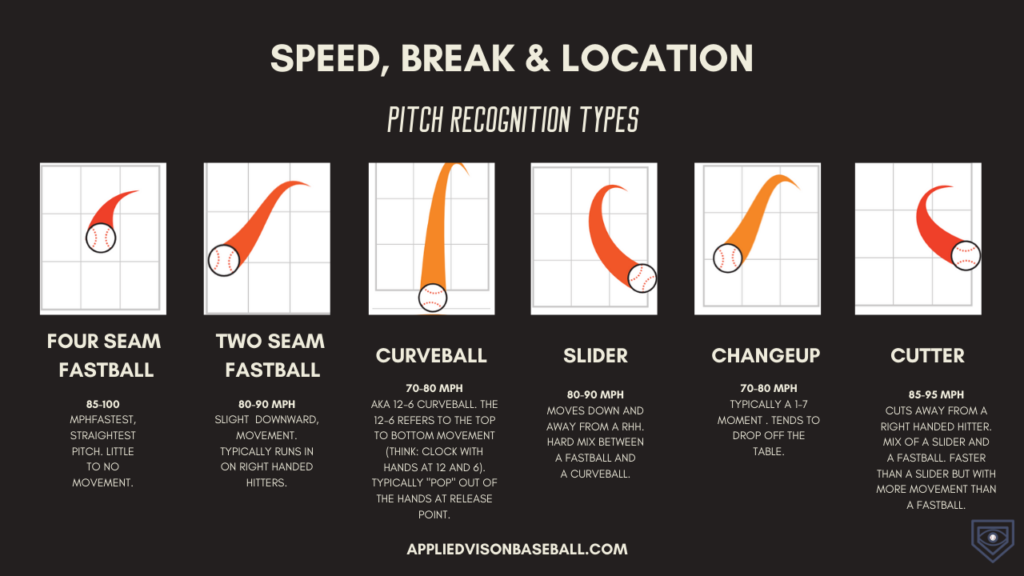

Necessary inputs

In [ ]:
import pandas as pd
import statistics
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

## Preparing the Data

The machine learning model I will build will consist of two separate datasets: one for training and one for testing. The dataset I will use for training will act as a sort of player profile system. As shown below, the training set will provide the model with the average movement and velocity each type of pitch thrown by every pitcher in the 2021 season.

In [ ]:
df = pd.read_csv('data/pitchTrainSet.csv')

#combine first and last names
df['last_name'] = df['first_name'] + ' ' + df['last_name']
df = df.rename(columns = {'last_name':'name'})
df = df.rename(columns = {'avg_speed':'Pitch Vel (MPH)'})
df = df.rename(columns = {'pitcher_break_z':'VBreak (In.)'})
df = df.rename(columns = {'pitcher_break_x':'HBreak (In.)'})
df = df.drop(columns = 'first_name')

df

,name,pitcher_id,Pitch Vel (MPH),pitch_type_name,VBreak (In.),HBreak (In.)
0,Robbie Ray,592662,94.8,4-Seamer,13.5,8.2
1,Sean Manaea,640455,92.1,Sinker,20.1,13.8
2,Tyler Mahle,641816,94.0,4-Seamer,13.9,12.1
3,Kevin Gausman,592332,94.6,4-Seamer,14.2,10.4
4,J.A. Happ,457918,91.0,4-Seamer,16.1,7.9
...,...,...,...,...,...,...
2257,Taylor Williams,592865,93.8,Sinker,29.1,16.1
2258,Kyle Wright,657140,93.0,Sinker,20.7,11.7
2259,Mauricio Llovera,661440,81.9,Slider,41.1,16.7
2260,Adam Conley,543045,86.5,Slider,36.8,2.6


For example, here are the average movement and velocities of all of Gerrit Cole's pitches from 2021.

In [4]:
df.loc[df['name'] == 'Gerrit Cole']

,name,pitcher_id,Pitch Vel (MPH),pitch_type_name,VBreak (In.),HBreak (In.)
7,Gerrit Cole,543037,97.7,4-Seamer,10.9,12.0
229,Gerrit Cole,543037,88.4,Slider,34.4,5.3
448,Gerrit Cole,543037,83.4,Curveball,51.6,10.5
538,Gerrit Cole,543037,89.8,Changeup,24.0,15.8


Using the **describe()** command will give stats for all columns of the dataframe. This can be used to see certain details about the data, such as the average pitch velocity or the standard deviation of vertical movement of pitches. 

In [5]:
df.describe()

,pitcher_id,Pitch Vel (MPH),VBreak (In.),HBreak (In.)
count,2262.000000,2262.000000,2262.000000,2262.000000
mean,603130.112732,87.713705,29.840141,9.156852
std,63846.459565,5.930816,13.310519,4.956264
min,425794.000000,65.800000,9.100000,0.000000
25%,571901.000000,83.500000,17.900000,5.000000
50%,613856.500000,87.600000,28.600000,8.900000
75%,656812.000000,92.900000,37.600000,13.400000
max,685503.000000,100.700000,74.300000,21.500000


For the testing sets, I will use data taken from 3 random games throughout the 2021 season in order to test how well the model can return the correct pitch. 

In [6]:
#fix pitch names to match training set
def fixPitchNames(df):
    for i in df:
        df = df.replace(to_replace = '4-Seam Fastball', value = '4-Seamer')
        df = df.replace(to_replace = 'Knuckle Curve', value = 'Curveball')
    return df
        

test1 = pd.read_csv('data/pitchTestSet1.csv', encoding= 'unicode_escape')
test1 = fixPitchNames(test1)
test2 = pd.read_csv('data/pitchTestSet2.csv', encoding= 'unicode_escape')
test2 = fixPitchNames(test2)
test3 = pd.read_csv('data/pitchTestSet3.csv', encoding= 'unicode_escape')
test3 = fixPitchNames(test3)

In [7]:
test1

,Pitcher,Pitch Type,Pitch Vel (MPH),VBreak (In.),HBreak (In.)
0,Brandon Workman,Curveball,78.7,60,5
1,Brandon Workman,4-Seamer,92.3,16,7
2,Brandon Workman,Curveball,77.5,61,8
3,Brandon Workman,Curveball,76.3,62,7
4,Brandon Workman,Curveball,76.9,60,5
...,...,...,...,...,...
310,Eduardo Rodriguez,Changeup,84.1,36,18
311,Eduardo Rodriguez,Cutter,87.7,27,2
312,Eduardo Rodriguez,Cutter,87.6,28,1
313,Eduardo Rodriguez,Changeup,81.2,34,14


In [8]:
test2

,Pitcher,Pitch Type,Pitch Vel (MPH),VBreak (In.),HBreak (In.)
0,Kenley Jansen,Cutter,92.7,15,7
1,Brusdar Graterol,Sinker,101.2,21,18
2,Brusdar Graterol,Sinker,101.7,17,18
3,Brusdar Graterol,Sinker,100.8,17,17
4,Brusdar Graterol,Sinker,100.8,15,17
...,...,...,...,...,...
286,Ian Anderson,4-Seamer,93.5,15,8
287,Ian Anderson,Changeup,88.2,24,11
288,Ian Anderson,Changeup,87.5,27,12
289,Ian Anderson,4-Seamer,93.4,14,5


In [9]:
test3

,Pitcher,Pitch Type,Pitch Vel (MPH),VBreak (In.),HBreak (In.)
0,Michael Fulmer,Slider,91.4,28,4
1,Michael Fulmer,Changeup,87.7,28,17
2,Michael Fulmer,Slider,90.3,28,2
3,Michael Fulmer,Slider,91.1,27,6
4,Michael Fulmer,Sinker,95.0,17,11
...,...,...,...,...,...
300,Spencer Turnbull,4-Seamer,93.9,18,3
301,Spencer Turnbull,Sinker,95.9,21,17
302,Spencer Turnbull,4-Seamer,94.7,14,4
303,Spencer Turnbull,Slider,85.6,37,6


## Building the Models

The machine learning model can be designed one of two ways: a **general pitch recognition model** or a **pitcher-specific model**. 

The **general pitch recognition model** only considers the movement and velocity of the pitch, without any regards to which pitcher is throwing it. This model aims to simply give a name to a pitch based on its velocity and recorded movement, which can be useful for any situation outside of MLB games, such as high school games or scouting camps, as long as the pitch velocity and movement can be accurately recorded.

The **pitcher-specific model** considers pitch movement and velocity, as well as which pitcher is throwing it. This model takes into account the pitch arsenal of the pitcher throwing the pitch. This helps to slightly mitigate the issue of a pitcher's curveball being classified as a slider, despite the potential similarity in movement and velocity. 

### 1) General Pitch Recognition Model

For the general pitch recognition model, we will drop the name and pitcher_id columns from our training set and testing sets.

In [10]:
genTest1 = test1.drop(columns = 'Pitcher')
genTest2 = test2.drop(columns = 'Pitcher')
genTest3 = test3.drop(columns = 'Pitcher')

df_train = df.drop(columns = ['name', 'pitcher_id'])
df_train

,Pitch Vel (MPH),pitch_type_name,VBreak (In.),HBreak (In.)
0,94.8,4-Seamer,13.5,8.2
1,92.1,Sinker,20.1,13.8
2,94.0,4-Seamer,13.9,12.1
3,94.6,4-Seamer,14.2,10.4
4,91.0,4-Seamer,16.1,7.9
...,...,...,...,...
2257,93.8,Sinker,29.1,16.1
2258,93.0,Sinker,20.7,11.7
2259,81.9,Slider,41.1,16.7
2260,86.5,Slider,36.8,2.6


Now I will split the training data into features and labels:
- Features (X_train) : avg_speed, pitcher_break_z, pitcher_break_x
- Labels (y_train) : pitch_type_name

In [11]:
X_train = df_train.drop(columns = 'pitch_type_name')
y_train = df_train['pitch_type_name']

Next I will split the testing data into features and labels:
- Features (X_test1, X_test2, X_test3) : Pitch Vel (MPH), VBreak (In.), HBreak (In.)
- Labels (y_test1, y_test2, y_test3) : Pitch Type

In [12]:
X_test1 = genTest1.drop(columns = 'Pitch Type')
X_test2 = genTest2.drop(columns = 'Pitch Type')
X_test3 = genTest3.drop(columns = 'Pitch Type')

y_test1 = genTest1['Pitch Type']
y_test2 = genTest2['Pitch Type']
y_test3 = genTest3['Pitch Type']

Now it is time to create and train the model. I will use the **Support Vector Classifier (SVC)** model for this program, since, after previous testing, it has proven to be the most effective for this data.

In [13]:
#Create the model
model = SVC()

#Train the model
model.fit(X_train, y_train)

SVC()

Now that the model has been created, it is time to test the model with our three sets of game data and examine the accuracy of the model.

In [14]:
#test set 1
predictions1 = model.predict(X_test1)
score1 = accuracy_score(y_test1, predictions1)
print('\nSet 1 Accuracy: ', 100*score1, '%')


#test set 2
predictions2 = model.predict(X_test2)
score2 = accuracy_score(y_test2, predictions2)
print('\nSet 2 Accuracy: ', 100*score2, '%')


#test set 3
predictions3 = model.predict(X_test3)
score3 = accuracy_score(y_test3, predictions3)
print('\nSet 3 Accuracy: ', 100*score3, '%')


#overall accuracy
predictions = list(predictions1) + list(predictions2) + list(predictions3)
test = list(y_test1) + list(y_test2) + list(y_test3)
score = accuracy_score(test, predictions)
print('\nAverage Accuracy: ', 100*score, '%')


Set 1 Accuracy:  86.34920634920636 %

Set 2 Accuracy:  83.8487972508591 %

Set 3 Accuracy:  92.1311475409836 %

Average Accuracy:  87.48627881448957 %


The average accuracy for the three datasets was about **87.5%**! This is a great score and shows that this model does a good job at determining which pitch is being thrown, even without knowing which pitcher is throwing the pitch. Let's see which pitches the model was confused with. 

In [15]:
#print out incorrect predictions
index = 0
count = 0
for i in y_test3:
    if i != predictions3[index]:
        print(i, predictions3[index])
        count = count+1
    index = index+1
    
print('\nNumber of confusions:', count)

Slider Cutter
Slider Cutter
Slider Cutter
Sinker 4-Seamer
Slider Cutter
Changeup Slider
Cutter Slider
Cutter Slider
Changeup Slider
Changeup Slider
Changeup Slider
Slider Curveball
Slider Curveball
Slider Curveball
Slider Curveball
4-Seamer Cutter
Changeup Slider
Changeup Slider
4-Seamer Cutter
Changeup Slider
Sinker 4-Seamer
Sinker 4-Seamer
Sinker 4-Seamer
Slider Curveball

Number of confusions: 24


According to this list, the model only mixed up pitches that are similar in nature, such as 4-seamers and Cutters, and Changeups and Sliders. These pitches can have very similar movement patterns and velocities. One pitcher's slider may have the exact movement and velocity as another pitcher's curveball. All in all, this model perfectly accomplishes the goal that was set for it, which is to provide the name of the pitch being thrown only based on movement and velocity without taking into consideration the pitcher who is throwing it. 

### 2) Pitcher-Specific Model

By filtering out the training data to only include a specific pitcher we wish to select, we can theoretically improve the accuracy of our ML model.

In [16]:
#filter training sets to only include pitchers in testing set
def filterSet(name):
    
    global X_train, y_train
        
    df_filtered = df.loc[df['name'] == name]

    X_train = df_filtered.drop(columns = ['name', 'pitcher_id', 'pitch_type_name'])
    y_train = df_filtered['pitch_type_name']

Here is an example of how the filter method filters out the train data set to only include a specified picture.

In [17]:
filterSet("Jacob deGrom")
X_train

,Pitch Vel (MPH),VBreak (In.),HBreak (In.)
180,99.2,11.4,9.1
552,91.6,28.9,4.7
1725,91.4,29.9,14.2


Now let's test out the filtering method.

In [18]:
#create the ML model
model = SVC()

#function to calculate accuracy of pitcher-specific model
def scorePitcherSpecific(testSet):
    scores = []
    for i in set(testSet['Pitcher']):
        found = True
        filterSet(i)
        try:
            model.fit(X_train, y_train)
        except ValueError:
            found = False
        if found:
            test_filtered = testSet.loc[testSet['Pitcher'] == i]
            y_test_filtered = test_filtered['Pitch Type']
            prediction = model.predict(test_filtered.drop(columns = ['Pitcher', 'Pitch Type']))
            scores.append(100*(accuracy_score(y_test_filtered, prediction)))
    return scores

#test set 1
scores1 = scorePitcherSpecific(test1)
print('\nSet 1 Accuracy: ', statistics.mean(scores1), '%')

#test set 2
scores2 = scorePitcherSpecific(test2)
print('\nSet 2 Accuracy: ', statistics.mean(scores2), '%')

#test set 3
scores3 = scorePitcherSpecific(test3)
print('\nSet 3 Accuracy: ', statistics.mean(scores3), '%')


#overall accuracy
averageScore = (statistics.mean(scores1) + statistics.mean(scores2) + statistics.mean(scores3)) / 3
print('\nAverage Accuracy: ', averageScore, '%')


Set 1 Accuracy:  95.85604293404805 %

Set 2 Accuracy:  97.30768200388454 %

Set 3 Accuracy:  98.37261503928171 %

Average Accuracy:  97.17877999240477 %


Using the pitcher-specific ML model, I was able to obtain an average accuracy of about **97.2%**! This proves that limiting the training data for the model to only containing the data for a pitcher we are currently analyzing highly increases the accuracy of the predictions made.

## Conclusion

Overall, I believe both models I created do a great job at identifying pitches. The general pitch recognition model can be extremely effective in identifying pitches thrown by non-MLB players, meanwhile, the pitcher-specific model does a great job at identifying pitches when the pitcher is in consideration. The filtering adjustment that I created is just one way in which the models can be improved, but I'm sure there are many other ways in which you can truly maximize their accuracies. Both of these models serve their purpose and are realistic examples of how machine learning can be utilized in collecting and analyzing baseball data.